# Solving Frozen Lake Problem Using Value Iteration and Linear Programming

Modified from: https://github.com/PacktPublishing/Hands-On-Reinforcement-Learning-with-Python/tree/master/Chapter03

## Goal:

Imagine, there is a frozen lake from your home to office, you should walk on the frozen lake
to reach your office. But oops! there will be a hole in the frozen lake in between, so you have
to be careful while walking in the frozen lake to avoid getting trapped at holes.
Look at the below figure where, 

1. S is the starting position (Home)
2. F is the Frozen lake where you can walk
3. H is the Hole which you have to be so careful about
4. G is the Goal (office)


![title](https://gymnasium.farama.org/_images/frozen_lake.gif)

 Okay, now let us use our agent instead of you to find the correct way to reach the office.
The agent goal is to find the optimal path to reach from S to G without getting trapped at H.
How an agent can achieve this? We give +1 point as a reward to the agent if it correctly
walks on the frozen lake and 0 points if it falls into the hole. So that agent could determine
which is the right action. An agent will now try to find the optimal policy. Optimal policy
implies taking the correct path which maximizes the agent reward. If the agent is
maximizing the reward, apparently agent is learning to skip the hole and reach the
destination.

First, we import necessary libraries

In [18]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



## Frozen Lake Environment Description

This document describes the Frozen Lake environment, a grid world game.

**Game Overview:**

The game takes place on a frozen lake grid world. The player starts at the top-left corner (location `[0,0]`) and must navigate to the goal located at the opposite corner (e.g., `[3,3]` for a 4x4 grid).  The lake contains holes, and falling into one results in a game over.  The ice is slippery (can be disabled), meaning the player might move in a direction perpendicular to their intended move.  Randomly generated worlds always guarantee a path to the goal.


**Action Space:**

The action space is a discrete 1-dimensional space with values ranging from 0 to 3, representing the movement direction:

*   `0`: Move Left
*   `1`: Move Down
*   `2`: Move Right
*   `3`: Move Up

**Observation Space:**

The observation is a single integer representing the player's current position. It's calculated as `current_row * ncols + current_col`, where `current_row` and `current_col` both start at 0.  For example, in a 4x4 grid, the goal position `[3,3]` would have an observation value of `3 * 4 + 3 = 15`. The total number of possible observations depends on the grid size.

**Starting State:**

The episode begins with the player at location `[0, 0]`, corresponding to observation `0`.

**Rewards:**

*   Reach Goal: `+1`
*   Reach Hole: `0`
*   Reach Frozen Tile: `0`

**Episode End:**

*   **Termination:**
    *   The player falls into a hole.
    *   The player reaches the goal (location `[max(nrow)-1, max(ncol)-1]`).
*   **Truncation (using `time_limit` wrapper):**
    *   Episode length reaches `100` steps for a 4x4 environment.
    *   Episode length reaches `200` steps for an 8x8 environment (FrozenLake8x8-v1).

Generated random map:
SFFFF
FHHFF
FFFFF
FHFFF
FFFFG

Initial state: 0


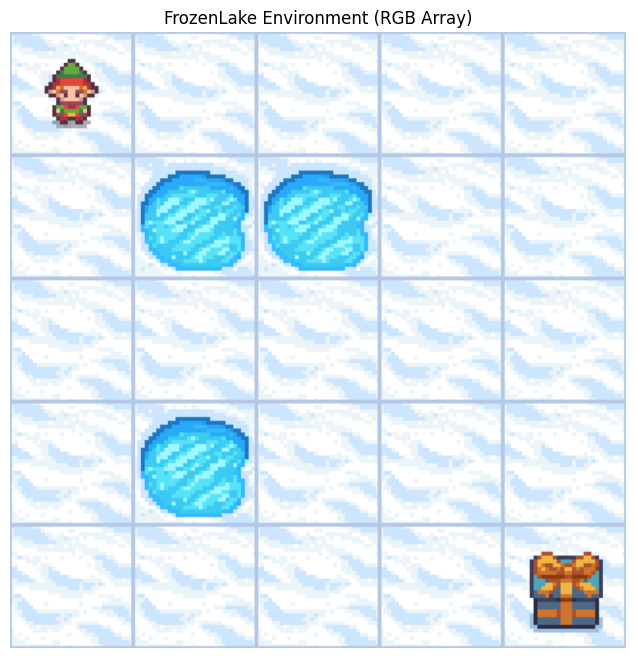


Environment Information:
Number of states: 25
Number of actions: 4

Transition Probabilities P(s'|s,a) for initial state:

Format: Action -> [Next State: Probability]

Action: LEFT
P(s'=0|s=0,a=0) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=0) = 0.33, Reward: 0.0, Done: False
P(s'=5|s=0,a=0) = 0.33, Reward: 0.0, Done: False

Action: DOWN
P(s'=0|s=0,a=1) = 0.33, Reward: 0.0, Done: False
P(s'=5|s=0,a=1) = 0.33, Reward: 0.0, Done: False
P(s'=1|s=0,a=1) = 0.33, Reward: 0.0, Done: False

Action: RIGHT
P(s'=5|s=0,a=2) = 0.33, Reward: 0.0, Done: False
P(s'=1|s=0,a=2) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=2) = 0.33, Reward: 0.0, Done: False

Action: UP
P(s'=1|s=0,a=3) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=3) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=3) = 0.33, Reward: 0.0, Done: False


In [19]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt

# First generate a random map
size = 5
random_map = generate_random_map(size=size)
print("Generated random map:")
for row in random_map:
    print(row)

# Function to create environment with specified render mode
def create_env(render_mode):
    return gym.make('FrozenLake-v1', render_mode=render_mode, desc=random_map)

# First show human render
env = create_env('human')
initial_state, _ = env.reset()
print(f"\nInitial state: {initial_state}")
env.render()  # This will show in a window
env.close()

# Then show rgb array render
env = create_env('rgb_array')
initial_state, _ = env.reset()
rgb_array = env.render()
plt.figure(figsize=(8, 8))
plt.imshow(rgb_array)
plt.axis('off')
plt.title('FrozenLake Environment (RGB Array)')
plt.show()

# Get state and action space information
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"\nEnvironment Information:")
print(f"Number of states: {n_states}")
print(f"Number of actions: {n_actions}")

# Extract transition probabilities P(s'|s,a) directly from the environment
P = np.zeros((n_states, n_actions, n_states))

# Get transition probabilities from the environment dynamics
print("\nTransition Probabilities P(s'|s,a) for initial state:")
print("\nFormat: Action -> [Next State: Probability]")

action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
initial_state = 0

for action in range(n_actions):
    print(f"\nAction: {action_names[action]}")
    # Get the transitions for this state-action pair
    transitions = env.unwrapped.P[initial_state][action]
    
    # Print and store each possible next state and its probability
    for prob, next_state, reward, done in transitions:
        print(f"P(s'={next_state}|s={initial_state},a={action}) = {prob:.2f}, Reward: {reward}, Done: {done}")
        # Store in our probability array
        P[initial_state, action, next_state] = prob



## Extract full transition dynamics and rewards


Full Transition Dynamics:

State 0:

Action: LEFT
P(s'=0|s=0,a=0) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=0) = 0.33, Reward: 0.0, Done: False
P(s'=5|s=0,a=0) = 0.33, Reward: 0.0, Done: False

Action: DOWN
P(s'=0|s=0,a=1) = 0.33, Reward: 0.0, Done: False
P(s'=5|s=0,a=1) = 0.33, Reward: 0.0, Done: False
P(s'=1|s=0,a=1) = 0.33, Reward: 0.0, Done: False

Action: RIGHT
P(s'=5|s=0,a=2) = 0.33, Reward: 0.0, Done: False
P(s'=1|s=0,a=2) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=2) = 0.33, Reward: 0.0, Done: False

Action: UP
P(s'=1|s=0,a=3) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=3) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=0,a=3) = 0.33, Reward: 0.0, Done: False

State 1:

Action: LEFT
P(s'=1|s=1,a=0) = 0.33, Reward: 0.0, Done: False
P(s'=0|s=1,a=0) = 0.33, Reward: 0.0, Done: False
P(s'=6|s=1,a=0) = 0.33, Reward: 0.0, Done: True

Action: DOWN
P(s'=0|s=1,a=1) = 0.33, Reward: 0.0, Done: False
P(s'=6|s=1,a=1) = 0.33, Reward: 0.0, Done: True
P(s'=2|s=1,a=1) = 0.33, Reward: 0.0, Do

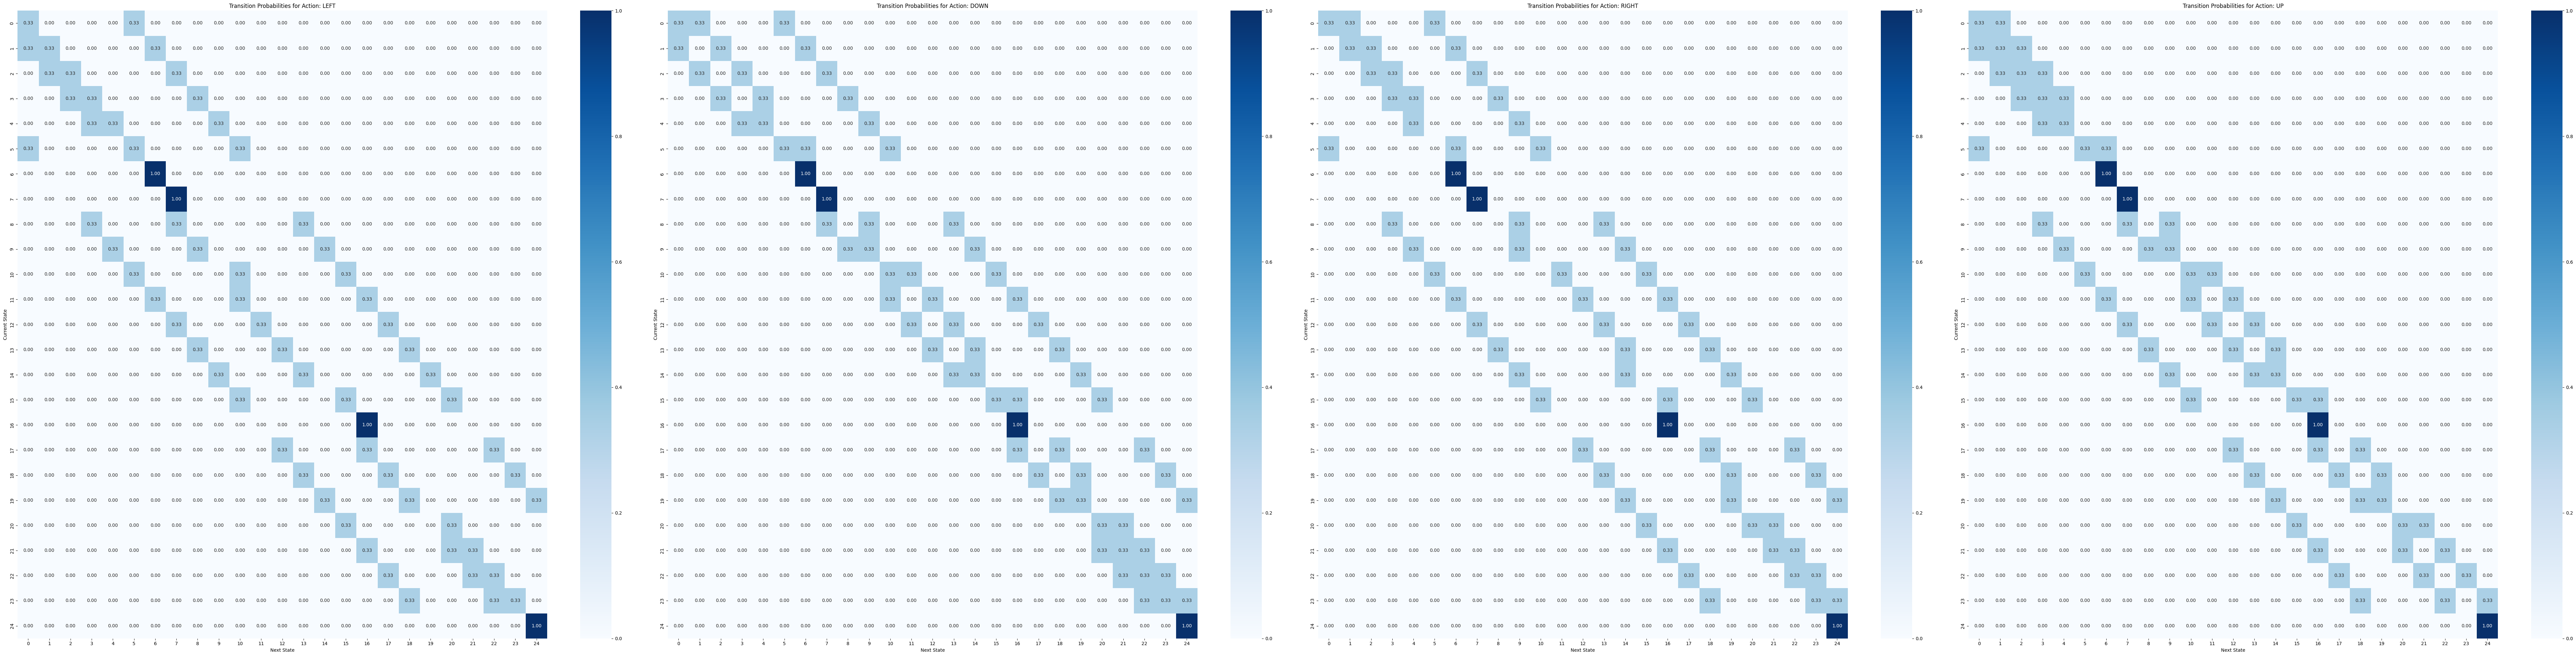

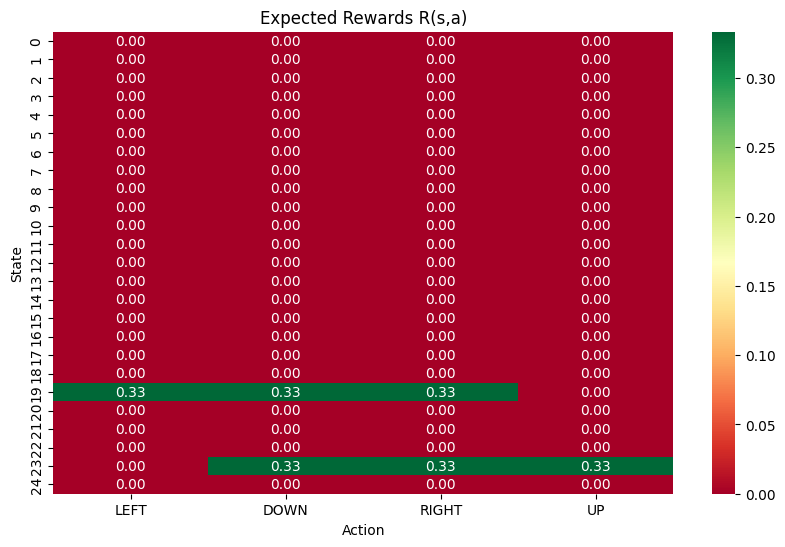

In [20]:


 
 

# Initialize transition and reward matrices
P = np.zeros((n_states, n_actions, n_states))  # P(s'|s,a)
R = np.zeros((n_states, n_actions))  # R(s,a)


# Extract full transition dynamics and rewards
print("\nFull Transition Dynamics:")
for state in range(n_states):
    print(f"\nState {state}:")
    for action in range(n_actions):
        print(f"\nAction: {action_names[action]}")
        transitions = env.unwrapped.P[state][action]
        
        # Calculate expected reward for this state-action pair
        expected_reward = 0
        for prob, next_state, reward, done in transitions:
            print(f"P(s'={next_state}|s={state},a={action}) = {prob:.2f}, "
                  f"Reward: {reward}, Done: {done}")
            P[state, action, next_state] = prob
            expected_reward += prob * reward
        
        R[state, action] = expected_reward

# Visualize transition probabilities for each action
plt.figure(figsize=(80, 20))
for action in range(n_actions):
    plt.subplot(1, 4, action + 1)
    sns.heatmap(P[:, action, :], annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Transition Probabilities for Action: {action_names[action]}')
    plt.xlabel('Next State')
    plt.ylabel('Current State')
plt.tight_layout()
plt.show()

# Visualize reward function
plt.figure(figsize=(10, 6))
sns.heatmap(R, annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Expected Rewards R(s,a)')
plt.xlabel('Action')
plt.ylabel('State')
yticks = np.arange(n_states)
plt.yticks(yticks + 0.5, yticks)
xticks = np.arange(n_actions)
plt.xticks(xticks + 0.5, action_names)
plt.show()


# Clean up
env.close()

## Value Iteration (V-version) on an 8 by 8 example

  

### Value Function (V-version)
The value function $V(s)$ represents the expected cumulative reward starting from state $s$ and following the optimal policy thereafter.

### Bellman Optimality Equation
The core of value iteration is based on the Bellman optimality equation:

$V_{k+1}(s) = \max_{a} \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma \cdot V_k(s')]$

Where:
- $V_k(s)$ is the value of state $s$ at iteration $k$
- $P(s'|s,a)$ is the transition probability to state $s'$ from state $s$ taking action $a$
- $R(s,a,s')$ is the reward received
- $\gamma$ is the discount factor
- $\max_a$ selects the action that maximizes the expected value

## Code Breakdown

1. **Initialization**:
   ```python
   value_table = np.zeros(env.observation_space.n)
   ```
   - Initialize value function to zero for all states
   - $V_0(s) = 0$ for all $s$

2. **Main Loop**:
   ```python
   for i in range(no_of_iterations):
       updated_value_table = np.copy(value_table)
   ```
   - Iteratively update the value function
   - Make a copy to ensure synchronous updates

3. **Q-Value Calculation**:
   ```python
   for state in range(env.observation_space.n):
       Q_value = []
       for action in range(env.action_space.n):
   ```
   For each state-action pair, calculate:
   $Q(s,a) = \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V(s')]$

4. **Probability and Reward Processing**:
   ```python
   for next_sr in env.unwrapped.P[state][action]:
       trans_prob, next_state, reward_prob, _ = next_sr
       next_states_rewards.append((trans_prob * (reward_prob + gamma * updated_value_table[next_state])))
   ```
   - Process each possible transition $(s'|s,a)$
   - Multiply transition probability with (reward + discounted future value)

5. **Value Update**:
   ```python
   value_table[state] = max(Q_value)
   ```
   This implements: $V_{k+1}(s) = \max_a Q(s,a)$

6. **Convergence Check**:
   ```python
   if (np.sum(np.fabs(updated_value_table - value_table)) <= threshold):
   ```
   - Check if the maximum change in value function is below threshold
   - $\max_s |V_{k+1}(s) - V_k(s)| \leq \epsilon$

## Implementation Details

- **Discount Factor** ($\gamma$): Default value of 1.0 (no discounting)
- **Convergence Threshold** ($\epsilon$): 1e-20
- **Maximum Iterations**: 100,000
- **Return Value**: Optimal value function $V^*(s)$

## Convergence Properties

- The algorithm is guaranteed to converge to the optimal value function if:
  - $\gamma < 1$ (discounted case), or
  - $\gamma = 1$ (undiscounted case) with a proper goal state
- Convergence rate is approximately linear in the discount factor $\gamma$

This implementation uses synchronous updates, meaning all states are updated based on the previous iteration's values, ensuring stability in the convergence process.

In [21]:
## Compute V^* function

def value_iteration(env, gamma=0.99):
    value_table = np.zeros(env.observation_space.n)
    no_of_iterations = 100000
    threshold = 1e-20
    
    for i in range(no_of_iterations):
        updated_value_table = np.copy(value_table)
        
        for state in range(env.observation_space.n):
            Q_value = []
            for action in range(env.action_space.n):
                # Calculate expected value for this action
                expected_value = 0
                for prob, next_state, reward, done in env.unwrapped.P[state][action]:
                    expected_value += prob * (reward + gamma * updated_value_table[next_state])
                Q_value.append(expected_value)
                
            value_table[state] = max(Q_value)
        
        if (np.sum(np.fabs(updated_value_table - value_table)) <= threshold):
            print(f'Value-iteration converged at iteration# {i+1}')
            break
    
    return value_table

## Extract greedy policy

def extract_policy(env, value_table, gamma = 0.99):
 
    # initialize the policy with zeros
    policy = np.zeros(env.observation_space.n) 
    
    
    for state in range(env.observation_space.n):
        
        # initialize the Q table for a state
        Q_table = np.zeros(env.action_space.n)
        
        # compute Q value for all ations in the state
        for action in range(env.action_space.n):
            for next_sr in env.unwrapped.P[state][action]: 
                trans_prob, next_state, reward_prob, _ = next_sr 
                Q_table[action] += (trans_prob * (reward_prob + gamma * value_table[next_state]))
        
        # select the action which has maximum Q value as an optimal action of the state
        policy[state] = np.argmax(Q_table)
    
    return policy

## Some helper functions

In [22]:
def print_state_info(env, state):
    """Print state information in different formats"""
    # Get grid dimensions
    n_rows = env.unwrapped.nrow
    n_cols = env.unwrapped.ncol
    
    # Convert state number to grid position
    row = state // n_cols
    col = state % n_cols
    
    print(f"State number: {state}")
    print(f"Grid position (row, col): ({row}, {col})")
    
    # Get the map
    desc = env.unwrapped.desc.copy()
    
    # Mark current position with 'P'
    desc = desc.tolist()
    old_char = desc[row][col]
    desc[row][col] = b'P'
    
    print("\nCurrent map (P marks current position, original tile was {}):\n".format(old_char.decode()))
    for row in desc:
        print("".join([c.decode('utf-8') for c in row]))

In [23]:
def plot_policy_grid(policy, desc, size=8):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw grid
    for i in range(size+1):
        ax.axhline(i, color='black', linewidth=1)
        ax.axvline(i, color='black', linewidth=1)
    
    # Set up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    
    # Dictionary for arrow directions
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    colors = {'S': 'green', 'F': 'lightblue', 'H': 'red', 'G': 'gold'}
    
    # Fill cells and add arrows
    for i in range(size):
        for j in range(size):
            state = i * size + j
            cell_type = desc[i][j].decode('utf-8')
            
            # Fill cell color based on type
            rect = plt.Rectangle((j, i), 1, 1, facecolor=colors[cell_type], alpha=0.3)
            ax.add_patch(rect)
            
            # Add cell type
            ax.text(j+0.1, i+0.2, cell_type, fontsize=12)
            
            # Add arrow for policy (except in holes and goal)
            if cell_type not in ['H', 'G']:
                action = int(policy[state])
                ax.text(j+0.5, i+0.5, arrows[action], fontsize=20, ha='center', va='center')
    
    plt.title('Optimal Policy\n(S: Start, F: Frozen, H: Hole, G: Goal)\n(←: Left, →: Right, ↑: Up, ↓: Down)')
    plt.show()

In [24]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

def plot_trajectory_grid(trajectory, desc, size=8):
    """
    Plots the grid with the trajectory overlay.
    """
    # Create figure with GridSpec to make room for colorbar
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(1, 20, figure=fig)
    ax = fig.add_subplot(gs[:, :-1])  # Main plot
    cax = fig.add_subplot(gs[:, -1])  # Colorbar axis
    
    # Draw grid
    for i in range(size+1):
        ax.axhline(i, color='black', linewidth=1)
        ax.axvline(i, color='black', linewidth=1)
    
    # Set up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    
    # Colors for different cell types
    colors = {'S': 'green', 'F': 'lightblue', 'H': 'red', 'G': 'gold'}
    
    # Create colormap for trajectory
    n_steps = len(trajectory)
    cmap = plt.cm.Reds
    
    # Fill cells and mark trajectory
    for i in range(size):
        for j in range(size):
            state = i * size + j
            cell_type = desc[i][j].decode('utf-8')
            
            # Fill cell color based on type
            rect = plt.Rectangle((j, i), 1, 1, facecolor=colors[cell_type], alpha=0.3)
            ax.add_patch(rect)
            
            # Add cell type
            ax.text(j+0.1, i+0.2, cell_type, fontsize=12)
            
            # Mark trajectory steps
            for step, traj_state in enumerate(trajectory):
                if state == traj_state:
                    color = cmap(float(step) / max(1, n_steps-1))
                    circle = plt.Circle((j+0.5, i+0.5), 0.3, color=color, alpha=0.6)
                    ax.add_patch(circle)
                    # Add step number
                    ax.text(j+0.5, i+0.5, str(step), ha='center', va='center', 
                           color='white', fontweight='bold', fontsize=8)
    
    # Add colorbar
    norm = plt.Normalize(0, n_steps-1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, cax=cax, label='Step number')
    
    # Print trajectory information
    ax.set_title('Policy Trajectory\n(S: Start, F: Frozen, H: Hole, G: Goal)\n'
                f'Steps: {n_steps}, States: {trajectory}')
    
    plt.tight_layout()
    plt.show()

def simulate_trajectory(env, policy, max_steps=400):
    """
    Simulates a trajectory using the given policy.
    """
    state, _ = env.reset()
    trajectory = [state]
    total_reward = 0
    
    for _ in range(max_steps):
        action = int(policy[state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        trajectory.append(next_state)
        
        if terminated or truncated:
            break
            
        state = next_state
    
    return trajectory, total_reward



## Run the code 

Initial State:
State number: 0
Grid position (row, col): (0, 0)

Current map (P marks current position, original tile was S):

PFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Start Value iteration: 
Value-iteration converged at iteration# 1126


Optimal Value Function:
[[0.41464036 0.42720522 0.44614822 0.46832037 0.49244371 0.51656983
  0.53526151 0.54097522]
 [0.41168642 0.42120783 0.43749572 0.45838855 0.48324013 0.51353178
  0.54576786 0.55736841]
 [0.39675209 0.39384054 0.37549627 0.         0.42167799 0.49381921
  0.56121207 0.5858589 ]
 [0.36927228 0.35298254 0.30653123 0.20040371 0.30075275 0.
  0.56901589 0.62825904]
 [0.33266395 0.29137537 0.19730918 0.         0.28929026 0.36195181
  0.53481945 0.68969732]
 [0.30613635 0.         0.         0.08627639 0.2139326  0.27271394
  0.         0.77203552]
 [0.2888856  0.         0.05769641 0.04751102 0.         0.25052148
  0.         0.87776874]
 [0.28038897 0.20081512 0.12732657 0.         0.23959086 0.486

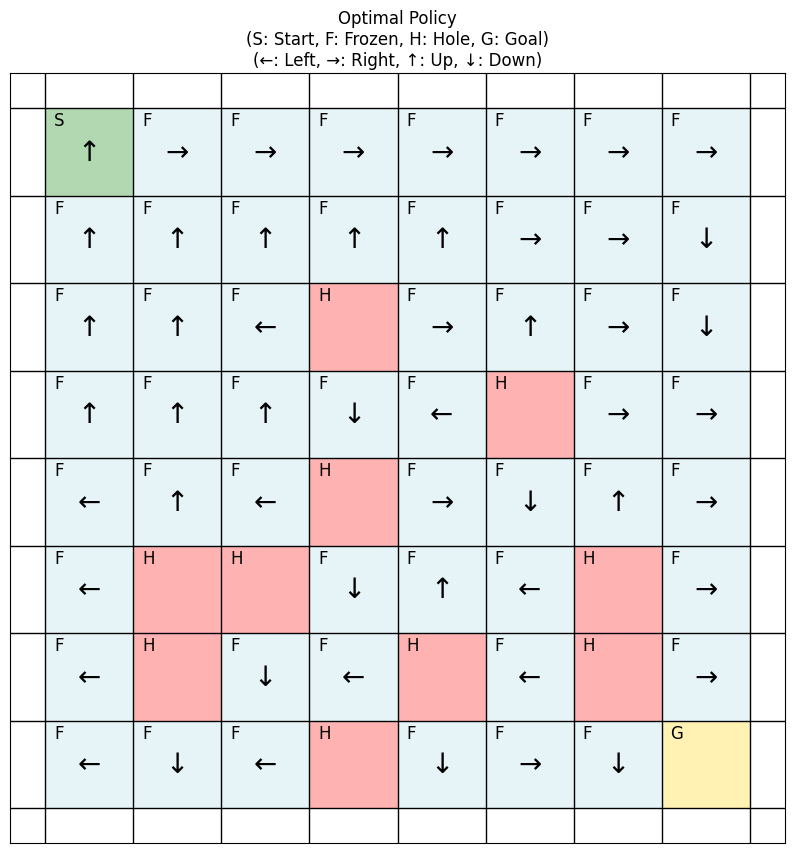

In [25]:

size = 8
env = gym.make('FrozenLake-v1',  desc=None, map_name="8x8", is_slippery=True)

initial_state, _ = env.reset()

# Print state information
print("Initial State:")
print_state_info(env, initial_state)

print("\nStart Value iteration: ")
# Run value iteration
optimal_value_function = value_iteration(env, gamma=0.99)
print("\n\nOptimal Value Function:")
print(optimal_value_function.reshape(size, size))

# Extract optimal policy
optimal_policy = extract_policy(env, optimal_value_function, gamma=0.99)
print("\nOptimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):")
print(optimal_policy.reshape(size, size))

# Visualize the policy
plot_policy_grid(optimal_policy, env.unwrapped.desc, size)


env.close()

## Run the code on a deterministic environment (settting is_slippery = False)

Value-iteration converged at iteration# 15

Optimal Value Function:
[[0.87752102 0.88638487 0.89533825 0.90438208 0.91351725 0.92274469
  0.93206535 0.94148015]
 [0.88638487 0.89533825 0.90438208 0.91351725 0.92274469 0.93206535
  0.94148015 0.95099005]
 [0.89533825 0.90438208 0.91351725 0.         0.93206535 0.94148015
  0.95099005 0.96059601]
 [0.90438208 0.91351725 0.92274469 0.93206535 0.94148015 0.
  0.96059601 0.970299  ]
 [0.89533825 0.90438208 0.91351725 0.         0.95099005 0.96059601
  0.970299   0.9801    ]
 [0.88638487 0.         0.         0.95099005 0.96059601 0.970299
  0.         0.99      ]
 [0.89533825 0.         0.93206535 0.94148015 0.         0.9801
  0.         1.        ]
 [0.90438208 0.91351725 0.92274469 0.         0.9801     0.99
  1.         0.        ]]

Optimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 2. 1. 1.]
 [2. 2. 2. 2. 1. 0. 1. 1.]
 [2. 2. 3. 0. 1. 1. 2. 1.]
 [1. 0. 0. 2. 2. 1. 0. 

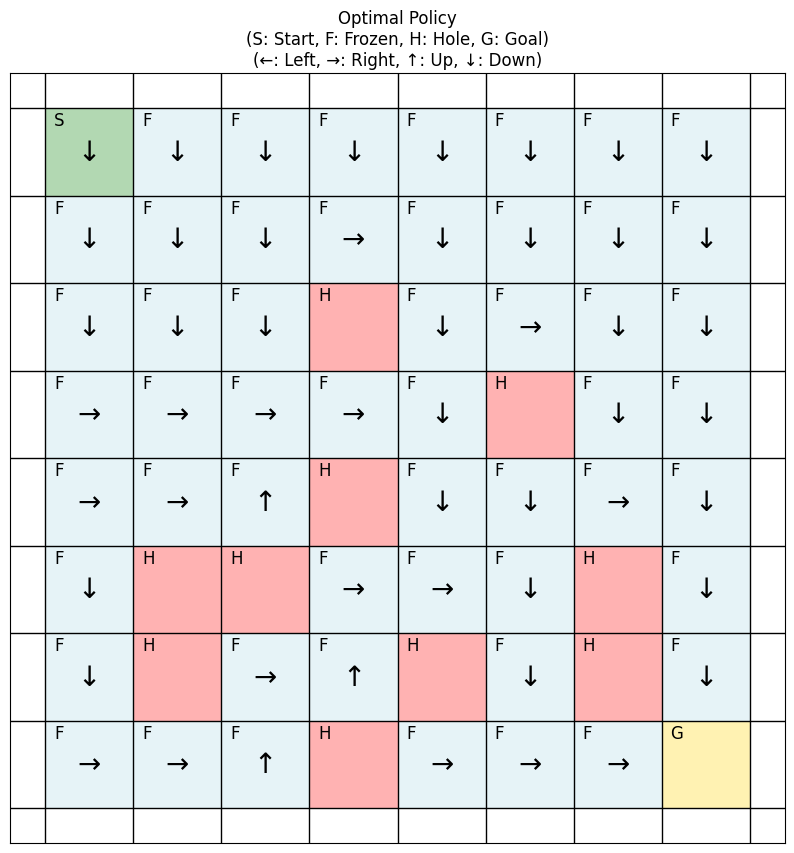

Trajectory length: 15
Total reward: 1.0
States visited: [0, 8, 16, 24, 25, 26, 27, 28, 36, 44, 45, 53, 61, 62, 63]


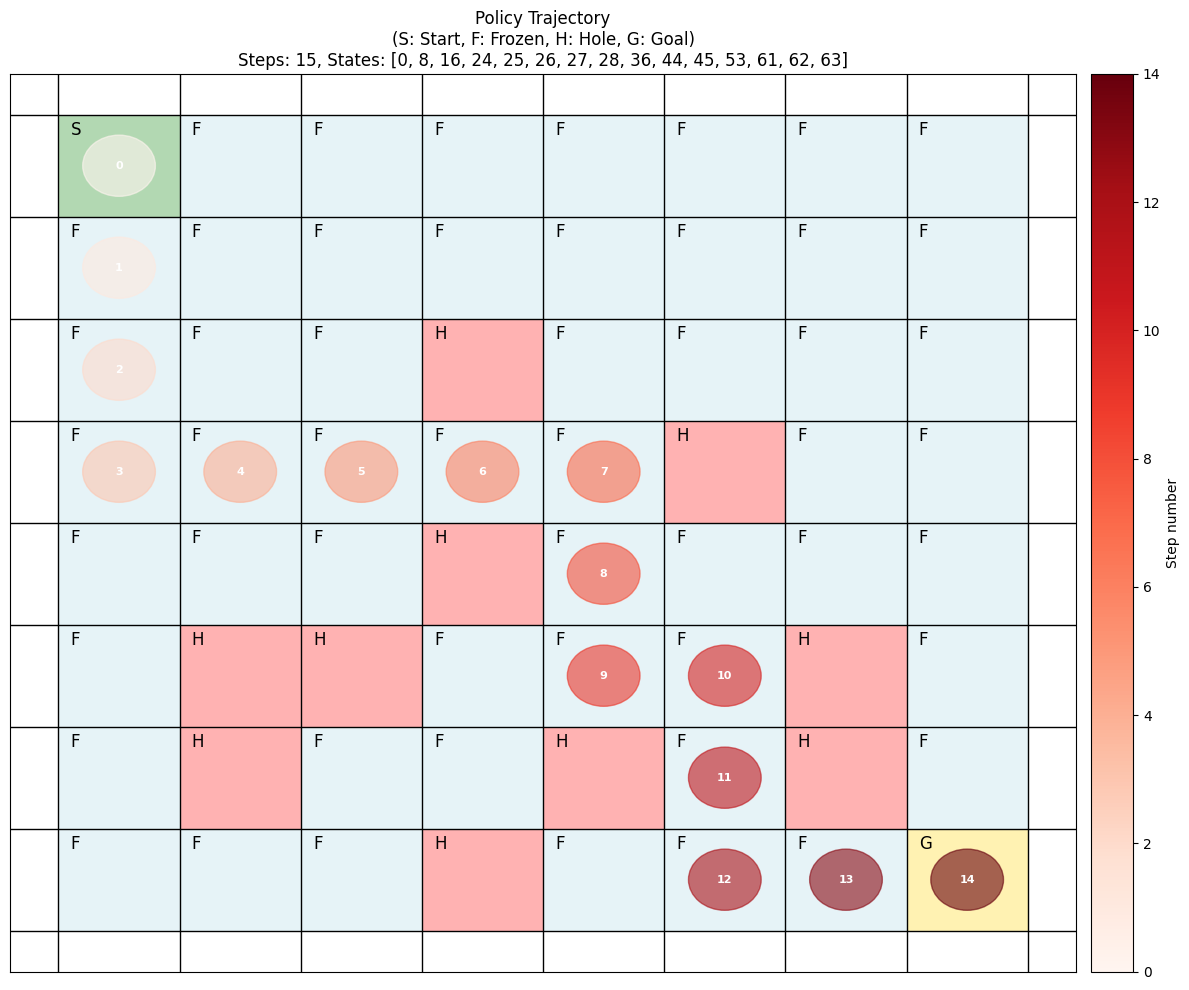

In [26]:

env = gym.make('FrozenLake-v1',  desc=None, map_name="8x8", is_slippery=False)


# Run value iteration
optimal_value_function = value_iteration(env, gamma=0.99)
print("\nOptimal Value Function:")
print(optimal_value_function.reshape(size, size))

# Extract optimal policy
optimal_policy = extract_policy(env, optimal_value_function, gamma=0.99)
print("\nOptimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):")
print(optimal_policy.reshape(size, size))

# Visualize the policy
plot_policy_grid(optimal_policy, env.unwrapped.desc, size)


trajectory, total_reward = simulate_trajectory(env, optimal_policy)
print(f"Trajectory length: {len(trajectory)}")
print(f"Total reward: {total_reward}")
print(f"States visited: {trajectory}")

# Plot the trajectory
plot_trajectory_grid(trajectory, env.unwrapped.desc, size)

env.close()

# Value Iteration (Q-version)


The Bellman optimality equation for V* is:

$V^*(s) = \max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^*(s')]$

### Q-function Version
The Bellman optimality equation for Q* is:

$Q^*(s,a) = \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma \max_{a'} Q^*(s',a')]$
 

Key differences from the V-function version:

1. Data Structure:
   - Instead of a value table V(s), we maintain a Q-table Q(s,a)
   - Q-table has shape (n_states, n_actions)

2. Update Rule:
   - V-function: Updates V(s) using max over Q-values
   - Q-function: Updates Q(s,a) directly using max over next state's Q-values

3. Policy Extraction:
   - V-function: Requires computing Q-values again
   - Q-function: Direct argmax over actions in Q-table


In [27]:
def q_value_iteration(env, gamma=0.99):
    """
    Implements Q-function version of value iteration algorithm.
    
    Args:
        env: Gymnasium environment
        gamma: Discount factor
    
    Returns:
        Q_table: Optimal Q-function
        policy: Optimal policy
    """
    # Initialize Q-table with zeros for all state-action pairs
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q_table = np.zeros((n_states, n_actions))
    
    # Parameters
    no_of_iterations = 100000
    threshold = 1e-20
    
    for i in range(no_of_iterations):
        # Make a copy of the current Q-table for updates
        updated_Q_table = np.copy(Q_table)
        
        # Update each state-action pair
        for state in range(n_states):
            for action in range(n_actions):
                # Calculate expected value for this state-action pair
                expected_value = 0
                
                # Get all possible transitions for this state-action pair
                transitions = env.unwrapped.P[state][action]
                
                # Calculate new Q-value using the Bellman equation
                for prob, next_state, reward, _ in transitions:
                    # Q(s,a) = Σ P(s'|s,a)[R(s,a,s') + γ max_a' Q(s',a')]
                    expected_value += prob * (reward + gamma * np.max(Q_table[next_state]))
                
                updated_Q_table[state, action] = expected_value
        
        # Check for convergence
        if np.sum(np.fabs(updated_Q_table - Q_table)) <= threshold:
            print(f'Q-value iteration converged at iteration# {i+1}')
            break
            
        Q_table = updated_Q_table
    
    # Extract policy from Q-table
    policy = np.argmax(Q_table, axis=1)
    
    return Q_table, policy

def print_q_values(Q_table, size=8):
    """
    Prints Q-values in a readable format.
    """
    action_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']
    for state in range(size * size):
        print(f"\nState {state}:")
        for action, value in enumerate(Q_table[state]):
            print(f"  {action_names[action]}: {value:.4f}")


Q-value iteration converged at iteration# 16

Optimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):
[[1 1 1 1 1 1 1 1]
 [1 1 1 2 1 1 1 1]
 [1 1 1 0 1 2 1 1]
 [2 2 2 2 1 0 1 1]
 [2 2 3 0 1 1 2 1]
 [1 0 0 2 2 1 0 1]
 [1 0 2 3 0 1 0 1]
 [2 2 3 0 2 2 2 0]]


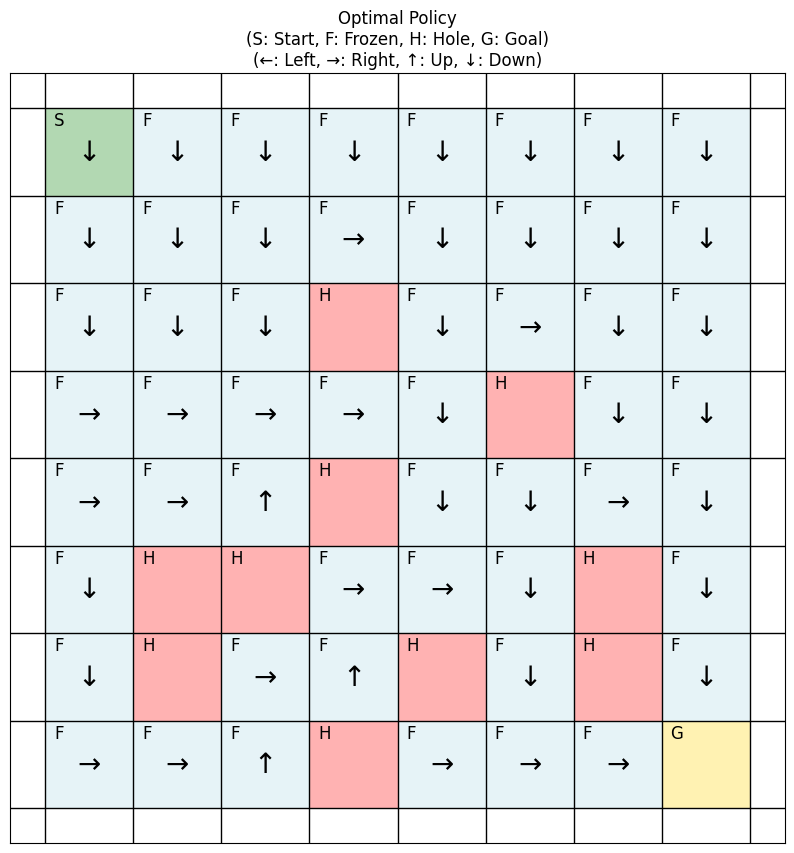

In [28]:
# Create environment
env = gym.make('FrozenLake-v1',  desc=None, map_name="8x8", is_slippery=False)

# Run Q-value iteration
Q_table, optimal_policy = q_value_iteration(env, gamma=0.99)

# # Print results
# print("\nOptimal Q-values:")
# print_q_values(Q_table, size)

print("\nOptimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):")
print(optimal_policy.reshape(size, size))

# Visualize the policy
plot_policy_grid(optimal_policy, env.unwrapped.desc, size)

env.close()

# Linear programming 


The Bellman equation can be written as a set of linear constraints:

For all states s and actions a:
$V(s) \geq \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V(s')]$

Our objective is to minimize the sum of values:
$\min_V \sum_s V(s)$

### Complete LP Formulation:
```
minimize   \sum_s V(s)
subject to  V(s) ≥ \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma \cdot V(s')] for all s,a
            V(s) free
```


In [29]:
import numpy as np
from scipy import optimize
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

def extract_P_R(env):
    """
    Extract transition probabilities and rewards from environment.
    Returns P[s,a,s'] and R[s,a,s']
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    P = np.zeros((n_states, n_actions, n_states))
    R = np.zeros((n_states, n_actions, n_states))
    
    for state in range(n_states):
        for action in range(n_actions):
            for prob, next_state, reward, _ in env.unwrapped.P[state][action]:
                P[state, action, next_state] += prob
                R[state, action, next_state] = reward
                
    return P, R

def solve_mdp_lp(env, gamma=0.99):
    """
    Solve MDP using linear programming.
    
    Args:
        env: Gymnasium environment
        gamma: Discount factor
    
    Returns:
        V: Optimal value function
        policy: Optimal policy
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Extract P and R matrices
    P, R = extract_P_R(env)
    
    # Number of constraints: one for each state-action pair
    n_constraints = n_states * n_actions
    
    # Construct constraint matrix A and vector b
    # V(s) - γΣs' P(s'|s,a)V(s') ≥ Σs' P(s'|s,a)R(s,a,s')
    A = np.zeros((n_constraints, n_states))
    b = np.zeros(n_constraints)
    
    constraint_idx = 0
    for s in range(n_states):
        for a in range(n_actions):
            # Coefficient for V(s)
            A[constraint_idx, s] = 1
            
            # Coefficients for V(s') terms
            for s_next in range(n_states):
                A[constraint_idx, s_next] -= gamma * P[s, a, s_next]
                
            # Right hand side: expected immediate reward
            b[constraint_idx] = np.sum(P[s, a, :] * R[s, a, :])
            
            constraint_idx += 1
    
    # Objective: minimize sum of V(s)
    c = np.ones(n_states)
    
    # Solve linear program
    result = optimize.linprog(c, A_ub=-A, b_ub=-b, method='highs')
    
    if result.success:
        V = result.x
        
        # Extract policy
        policy = np.zeros(n_states, dtype=int)
        for s in range(n_states):
            values = np.zeros(n_actions)
            for a in range(n_actions):
                values[a] = np.sum(P[s, a, :] * (R[s, a, :] + gamma * V))
            policy[s] = np.argmax(values)
            
        return V, policy
    else:
        raise ValueError("Linear programming solution failed")




Optimal Value Function:
[[0.87752102 0.88638487 0.89533825 0.90438208 0.91351725 0.92274469
  0.93206535 0.94148015]
 [0.88638487 0.89533825 0.90438208 0.91351725 0.92274469 0.93206535
  0.94148015 0.95099005]
 [0.89533825 0.90438208 0.91351725 0.         0.93206535 0.94148015
  0.95099005 0.96059601]
 [0.90438208 0.91351725 0.92274469 0.93206535 0.94148015 0.
  0.96059601 0.970299  ]
 [0.89533825 0.90438208 0.91351725 0.         0.95099005 0.96059601
  0.970299   0.9801    ]
 [0.88638487 0.         0.         0.95099005 0.96059601 0.970299
  0.         0.99      ]
 [0.89533825 0.         0.93206535 0.94148015 0.         0.9801
  0.         1.        ]
 [0.90438208 0.91351725 0.92274469 0.         0.9801     0.99
  1.         0.        ]]

Optimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):
[[1 1 1 1 1 1 1 1]
 [1 1 1 2 1 1 1 1]
 [1 1 1 0 1 2 1 1]
 [2 2 2 2 1 0 1 1]
 [2 2 3 0 1 1 2 1]
 [1 0 0 2 2 1 0 1]
 [1 0 2 3 0 1 0 1]
 [2 2 3 0 2 2 2 0]]


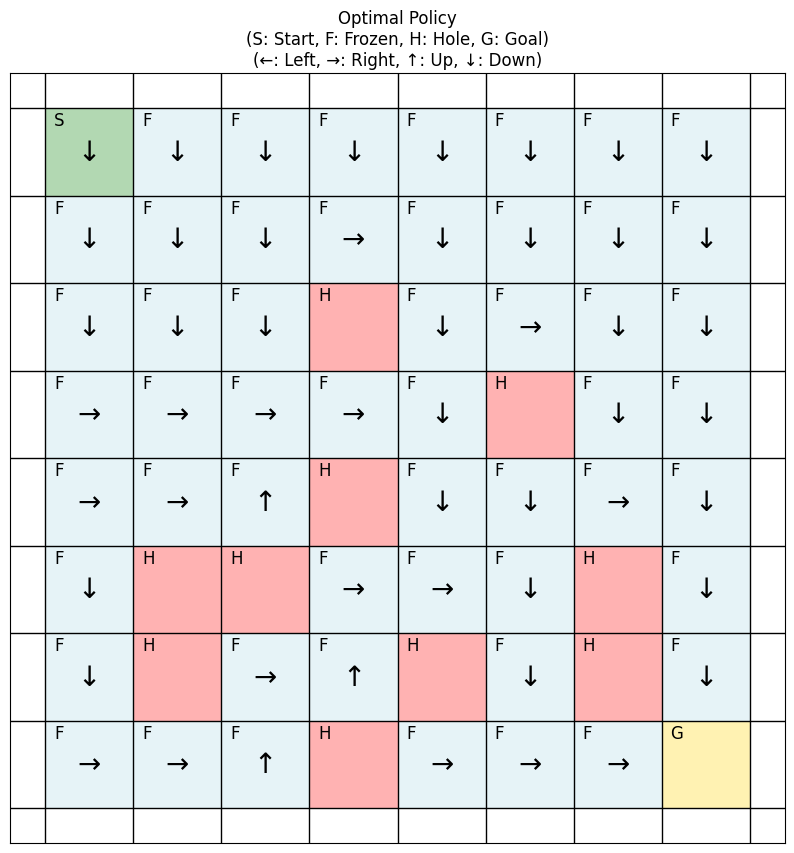

In [30]:
 # Create environment
env = gym.make('FrozenLake-v1',  desc=None, map_name="8x8", is_slippery=False)

# Solve using LP
V, policy = solve_mdp_lp(env)

# Print results
print("\nOptimal Value Function:")
print(V.reshape(size, size))
print("\nOptimal Policy (0:LEFT, 1:DOWN, 2:RIGHT, 3:UP):")
print(policy.reshape(size, size))

# Visualize the policy
plot_policy_grid(optimal_policy, env.unwrapped.desc, size)


env.close()

## Comparing these three methods -- Verify that they compute the same $V^*$

In [31]:


# Create environment
env = gym.make('FrozenLake-v1',  desc=None, map_name="8x8", is_slippery=True)

# Get V* from all three methods

V_vi = value_iteration(env, gamma=0.99) 
Q_table, _ = q_value_iteration(env, gamma=0.99)
V_q = np.max(Q_table, axis=1)
V_lp, _ = solve_mdp_lp(env, gamma=0.99)


# Print the map
print("\nEnvironment Map:")
for row in random_map:
    print(row)

# Print all three V* and their differences
print("\nV* from Value Iteration:")
print(V_vi.reshape(size, size))

print("\nV* from Q-Value Iteration:")
print(V_q.reshape(size, size))

print("\nV* from Linear Programming:")
print(V_lp.reshape(size, size))

# Compare solutions
print("\nMaximum absolute differences:")
print(f"VI vs Q-VI: {np.max(np.abs(V_vi - V_q)):.10f}")
print(f"VI vs LP:   {np.max(np.abs(V_vi - V_lp)):.10f}")
print(f"Q-VI vs LP: {np.max(np.abs(V_q - V_lp)):.10f}")


env.close()

Value-iteration converged at iteration# 1126
Q-value iteration converged at iteration# 1127

Environment Map:
SFFFF
FHHFF
FFFFF
FHFFF
FFFFG

V* from Value Iteration:
[[0.41464036 0.42720522 0.44614822 0.46832037 0.49244371 0.51656983
  0.53526151 0.54097522]
 [0.41168642 0.42120783 0.43749572 0.45838855 0.48324013 0.51353178
  0.54576786 0.55736841]
 [0.39675209 0.39384054 0.37549627 0.         0.42167799 0.49381921
  0.56121207 0.5858589 ]
 [0.36927228 0.35298254 0.30653123 0.20040371 0.30075275 0.
  0.56901589 0.62825904]
 [0.33266395 0.29137537 0.19730918 0.         0.28929026 0.36195181
  0.53481945 0.68969732]
 [0.30613635 0.         0.         0.08627639 0.2139326  0.27271394
  0.         0.77203552]
 [0.2888856  0.         0.05769641 0.04751102 0.         0.25052148
  0.         0.87776874]
 [0.28038897 0.20081512 0.12732657 0.         0.23959086 0.48644206
  0.7371033  0.        ]]

V* from Q-Value Iteration:
[[0.41464036 0.42720522 0.44614822 0.46832037 0.49244371 0.51656983
 